# Deep-Learning-Based Neuron Detection in Brain Volumes
## *Written by Prerna Singh and John D'Uva* 

## Problem: In order to study morphology, connectivity, and firing characteristics of neurons, we need to know where they are located in the brain. Instead of a human manually going through terabytes of data to annotate cells, we propose a six-layer 3D convolutional neural network that can detect fluorescent neurons within given sections of a brain.

## Hypothesis: This model has been previously proven to show ~95% accuracy in CLARITY-cleared brains. We believe that it may be able to generalize – with a similar degree of success – to other datasets.


## Methods:
    1) Loop through an entire brain, looking at each 12x12x12 window (using a stride of 4 pixels)
    2) Use a brain-wide illumination correction for intensity 
    3) Test pre-trained m1 model on windows to detect all cells in the brain

### Original repo: https://github.com/prernasingh11/CLARITY

In [7]:
from brainlit.utils.session import NeuroglancerSession
import numpy as np
import os
import matplotlib.pyplot as plt
from cloudvolume import CloudVolume, view
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import sklearn.metrics

# Change the following path to your local installation of brainlit
sys.path.append("/Users/johnduva/Desktop/Git/NeuroData/brainlit") 

### Pull the full volume 

In [8]:
dir = "s3://open-neurodata/brainlit/brain1"
vol = CloudVolume(dir, parallel=False, mip=2, progress=True, fill_missing=True)

x1 = 0; x2 = vol.shape[0]
y1 = 0; y2 = vol.shape[1]
z1 = 0; z2 = vol.shape[2]

### Create list of 12x12x12 subvolumes and associated list of coords

In [ ]:
step = 500

stride = 4
final = []
coords = []
for x in range(x1, x2, step,):
    x500 = x+step
    image = vol[x:x500, y1:y2, z1:z2] 

    '''  Create a list "final" with each element being a 12x12x12 subvolume within the designated region '''
    count = 0
    for xx in range(0, x500-x-(12-stride), stride ):
        for y in range(0, y2-y1-(12-stride), stride ):
            for z in range(0, z2-z1-(12-stride), stride ):
                final.append( image[xx:xx+12, y:y+12, z:z+12] )
                coords.append( [x+xx+6, y1+y+6, z1+z+6] ) # Keep track of the coordinates of each subvolume in "coords"
#                 print( [x+xx+6, y1+y+6, z1+z+6] ) # print the coords of each subvolume's center voxel
#                 print(image[xx:xx+12, y:y+12, z:z+12].shape) # print the shape of each subvolume
#                 print(' ')
                count +=1

    print("There are " + str(count) + " subvolumes.")


In [44]:
# Test to make sure size of all subvolumes are correct
[print(f.shape) for f in final]

### Convert to desired shape: n x 12 x 12 x 12 x 1

In [45]:
final2 = np.zeros((len(final), 12, 12,12,1))
for i, subv in enumerate(final):
    final2[i] = np.asarray(subv)
final2 = np.squeeze(final2)

print("Number of Items in Test Data:", len(final2) )
final2 = np.expand_dims(final2, axis=1)
print("Shape of Test Data Vector:", final2.shape)

Number of Items in Test Data: 30497
Shape of Test Data Vector: (30497, 1, 12, 12, 12)


### Load Prernas model

In [156]:
class M1(nn.Module):
    def __init__(self):
        super(M1, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv3d(1,64, (5,5,5),padding = 2),nn.Dropout(dr)) # in_channel, out_channel, kernel
        self.pool = nn.MaxPool3d((2, 2, 2),2) # kernel, stride
        self.conv2 = nn.Sequential(nn.Conv3d(64, 64, (3,3,3), padding = 1), nn.Dropout(dr)) # in_channel, out_channel, kernel
        self.conv3 = nn.Sequential(nn.Conv3d(64, 64, (3,3,3), padding = 1), nn.Dropout(dr)) # in_channel, out_channel, kernel
        self.fc1 = nn.Sequential(nn.Linear(6*6*6*64,150),nn.Dropout(dr))
        self.fc2 = nn.Sequential(nn.Linear(150,1),nn.Dropout(dr))

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.reshape(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        m = nn.Sigmoid()
        x = m(x)
        return x

#Hyperparamters
num_epochs = 200
batch_size = 5
learning_rate = 1e-3
momentum = 0.9
dr = 0.3
weight_decay = 1e-4
m1 = M1()
m1.load_state_dict(torch.load('crossvalidation4.pt', map_location = torch.device('cpu') ))
m1 = m1.double()

### Normalize

In [157]:
MAX = np.amax(final2)
final_norm = final2/MAX

### Run subvolumes through model to get list of classification scores

In [158]:
labels_norm=[]
for i in range(len(labels_norm), len(final_norm)):
    w = torch.from_numpy(final_norm[i])
    w = w.unsqueeze(1)
    w = w.double()
    w = m1(w)
    labels_norm.append(w.detach().numpy())

labels_norm = np.asarray(labels_norm)
labels_norm = labels_norm.squeeze()
print(len(labels_norm))

274625


### Order the list from most-likely to be a cell to least-likely...

In [346]:
arr = [[float(test), i, final_norm[i].squeeze()] for i, test in enumerate(labels_norm)] 
arr.sort(reverse=True)
onlyScores = [item[0] for item in arr[:20]]
# onlyScores[:10]

### Display subvolumes in order of highest scores to lowest. Manually look through them to determine reliability.

Using the 1st highest-scoring subvolume (coodinates=[4160, 3960, 1762])...
filter out the other high-scoring subvolumes that are too close: 
  jj=1 removing [4160, 3957, 1762]
  jj=2 removing [4163, 3960, 1762]
  jj=3 removing [4157, 3957, 1762]
  jj=4 removing [4166, 3960, 1762]
  jj=5 coords are far away...
  jj=6 removing [4157, 3960, 1762]
  jj=7 coords are far away...
  jj=8 removing [4166, 3957, 1762]
  jj=9 coords are far away...
  jj=10 coords are far away...
  jj=11 coords are far away...
  jj=12 coords are far away...
  jj=13 coords are far away...
  jj=14 removing [4169, 3960, 1762]
  jj=15 coords are far away...
  jj=16 coords are far away...
  jj=17 coords are far away...
  jj=18 coords are far away...
  jj=19 coords are far away...
 
Using the 2nd highest-scoring subvolume (coodinates=[4160, 3957, 1762])...
continue because we already removed this duplicate subvolume from arr.

Using the 3rd highest-scoring subvolume (coodinates=[4163, 3960, 1762])...
continue because we 

<Figure size 432x288 with 0 Axes>

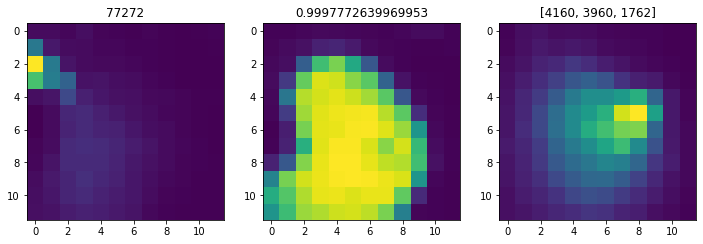

<Figure size 432x288 with 0 Axes>

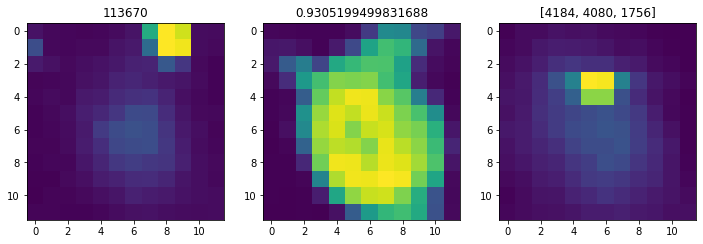

<Figure size 432x288 with 0 Axes>

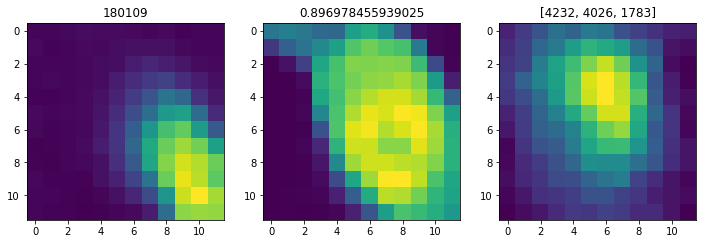

<Figure size 432x288 with 0 Axes>

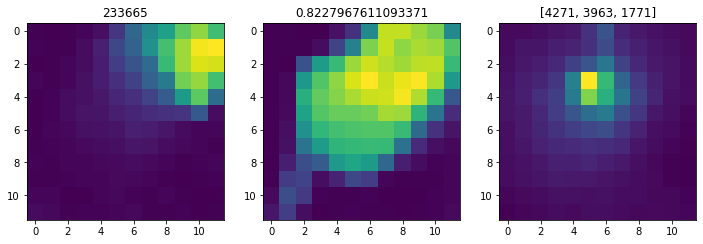

<Figure size 432x288 with 0 Axes>

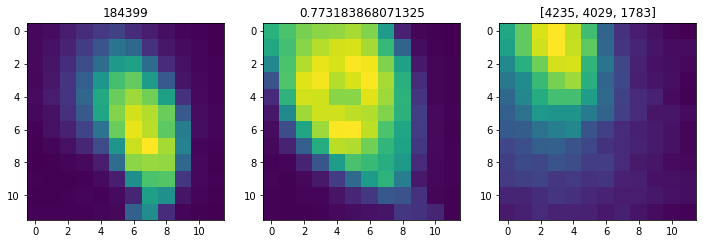

<Figure size 432x288 with 0 Axes>

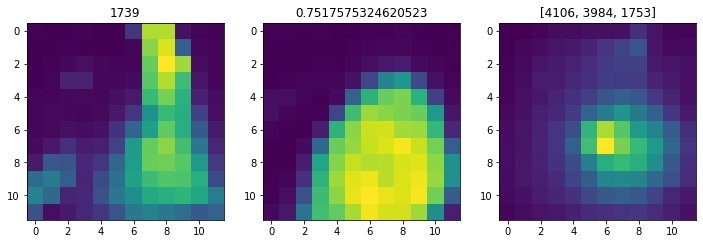

<Figure size 432x288 with 0 Axes>

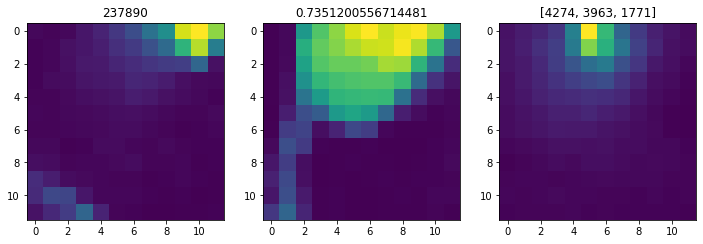

<Figure size 432x288 with 0 Axes>

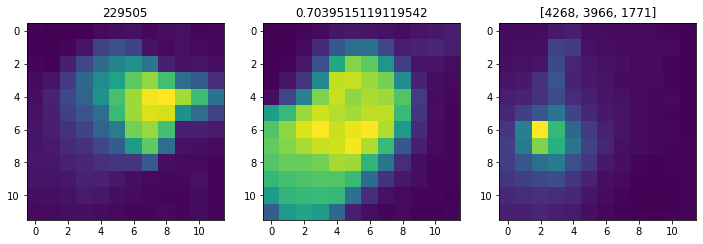

In [356]:
begin = 0; end = 20
skip = []
dist = 15

for ii, subvol in enumerate(arr[begin:end]): 
    threeCoords = coords[subvol[1]] 
    suffix = "th" if 4<=ii+1%100<=20 else {1:"st",2:"nd",3:"rd"}.get(ii+1%10, "th")
    print("Using the " + str(ii+1) + suffix +" highest-scoring subvolume (coodinates=" + str(threeCoords) +')...')
    if ii in skip:
        print("continue because we already removed this duplicate subvolume from arr.\n")
        continue
    else:
        fig = plt.figure()
        f, axarr = plt.subplots(1,3, figsize=(12,12) )  
        axarr[0].imshow(subvol[2][:,:,3] )
        axarr[1].imshow(subvol[2][:,:,6] )
        axarr[2].imshow(subvol[2][:,:,9] )

        axarr[0].set_title( subvol[1] ) 
        axarr[1].set_title( subvol[0] ) 
        axarr[2].set_title( coords[subvol[1]] ) 
        
        print("filter out the other high-scoring subvolumes that are too close: ")
        for jj, subvol2 in enumerate(arr[begin+ii+1 : end]): 
            jj = begin+ii+1+jj
            threeCoords2 = coords[subvol2[1]]           
            if abs(threeCoords[0]-threeCoords2[0])>dist or abs(threeCoords[1]-threeCoords2[1])>dist or abs(threeCoords[2]-threeCoords2[2])>dist:
                print('  jj=' + str(jj) + ' coords are far away...')
                pass
            else:
                print('  jj=' + str(jj) + " removing " + str(threeCoords2) )
                arr.remove(arr[jj])
                skip.append(jj)
        print(' ')    